<a href="https://colab.research.google.com/github/DLPY/Classification_Session_1/blob/main/Churn_Random_Forest_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset used**

Churn Modelling: https://www.kaggle.com/shrutimechlearn/churn-modelling

# Step 1: Import the relelvant packages and read the dataset

In [3]:
# import libraries 

import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis 
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
%matplotlib inline
import seaborn as sns # Statistical data visualization

#Scikit-Learn otherwise known as sklearn is used for machine learning and has functionality for many types of classification models
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             plot_roc_curve, PrecisionRecallDisplay, roc_auc_score, roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz # Visualize Tree
from collections import OrderedDict
from collections import Counter #Python Counter is a container that will hold the count of each of the elements present in the container
from imblearn.under_sampling import RandomUnderSampler # provides tools when dealing with classification with imbalanced classes

from pprint import pprint


In [4]:
# Load the data
# CSV is first read in from a github raw file another option is to import the notebook to your session storage by click on the file icon on left toolbar then importing csv
! wget https://raw.githubusercontent.com/DLPY/Classification_Session_1/master/Churn_Modelling.csv

--2022-02-11 07:10:13--  https://raw.githubusercontent.com/DLPY/Classification_Session_1/master/Churn_Modelling.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 684858 (669K) [text/plain]
Saving to: ‘Churn_Modelling.csv’

Churn_Modelling.csv 100%[===================>] 668.81K  --.-KB/s    in 0.03s   

2022-02-11 07:10:13 (21.3 MB/s) - ‘Churn_Modelling.csv’ saved [684858/684858]



In [5]:
#reading the input file
df_data = pd.read_csv('Churn_Modelling.csv')
df_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Churn Modeling Data Description**

This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed their account) or they continue to be a customer.

Here we have 13 feature columns and Exited is a target column.

Row Numbers: Row Numbers from 1 to 10000.

CustomerId: Unique Ids for bank customer identification.

Surname: Customer's last name.

CreditScore: Credit score of the customer.

Geography: The country from which the customer belongs(Germany/France/Spain).

Gender: Male or Female.

Age: Age of the customer.

Tenure: Number of years for which the customer has been with the bank.

Balance: Bank balance of the customer.

NumOfProducts: Number of bank products the customer is utilising.

HasCrCard: Binary Flag for whether the customer holds a credit card with the bank or not(0=No, 1=Yes).

IsActiveMember: Binary Flag for whether the customer is an active member with the bank or not(0=No, 1=Yes).

EstimatedSalary: Estimated salary of the customer in Euro.

Exited: Binary flag 1 if the customer closed account with bank and 0 if the customer is retained(0=No, 1=Yes).

# Step 2: Data Transformation

In [6]:
#Removing columns that do not add value to the analysis
df_data = df_data.drop(['RowNumber', 'CustomerId','Surname'],axis=1)
df_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Encoding the categorical variables - Change the text into numbers**

In [7]:
#Convert the categorical values into numeric categorical labels so that this data can be used for modelling.
df_data['CountryCode'] = df_data['Geography'].astype('category').cat.codes
df_data['GenderCode'] = df_data['Gender'].astype('category').cat.codes

In [8]:
df_data.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CountryCode,GenderCode
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,2,0


From the above, notice that:

The Geography and Gender have been converted to numeric values.

There are two new columns with these values: CountryCode and GenderCode.

In [9]:
#droping the string columns as we have the respective numeric columns
df_data = df_data.drop(['Geography', 'Gender'],axis=1)

**Choosing predictor variables and target variable for performing Classification
Target and Source variables** 


Target Variable: Exited

Predictor Variables: CreditScore, CountryCode, GenderCode, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary

In [10]:
X = df_data.drop(['Exited'],axis=1) #selecting all variables except "exited" as our predictor variables

y = df_data['Exited'] # selecting "Exited" column as our target variable

# Save this list of column values for later
columns_list = list(X.columns.values)

In [11]:
X.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,CountryCode,GenderCode
0,619,42,2,0.00,1,1,1,101348.88,0,0
1,608,41,1,83807.86,1,0,1,112542.58,2,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0
4,850,43,2,125510.82,1,1,1,79084.10,2,0


In [12]:
y.head(5)

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

# Split dataset into the training and test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

print('Training Data:', X_train.shape, y_train.shape)
print('Testing Data:', X_test.shape, y_test.shape)

Training Data: (7000, 10) (7000,)
Testing Data: (3000, 10) (3000,)


# Train, Test and Predict using a Random Forest Classifier model

**Model 1 : Baseline Model**

In [14]:
# Create an object using RandomForestClassifier with default parameters
randomforest_classifier_m1 = RandomForestClassifier(random_state =100)
# Fit the classification model to the training set data.
randomforest_classifier_m1.fit(X_train, y_train)

RandomForestClassifier(random_state=100)

In [15]:
#Check how the model predicts training data
y_predict_train = randomforest_classifier_m1.predict(X_train)
#creating confusion matrix
cm = confusion_matrix(y_train, y_predict_train)

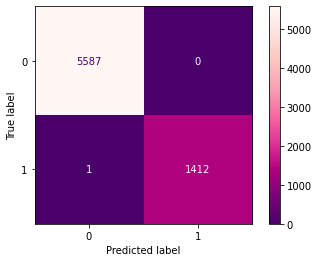

In [16]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train, y_predict_train, cmap='RdPu_r')
plt.grid(False)

In [17]:
#Classification report for training data 
print(classification_report(y_train, y_predict_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5587
           1       1.00      1.00      1.00      1413

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000



In [18]:
#Check how the model predicts testing data
y_predict_m1 = randomforest_classifier_m1.predict(X_test)
#creating confusion matrix
cm_m1 = confusion_matrix(y_test, y_predict_m1)

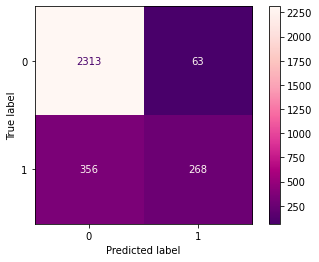

In [19]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_predict_m1, cmap='RdPu_r')
plt.grid(False)

In [20]:
#Classification report for testing data 
print(classification_report(y_test, y_predict_m1))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2376
           1       0.81      0.43      0.56       624

    accuracy                           0.86      3000
   macro avg       0.84      0.70      0.74      3000
weighted avg       0.85      0.86      0.84      3000



In [21]:
print('Parameters currently in use:\n')
pprint(randomforest_classifier_m1.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}


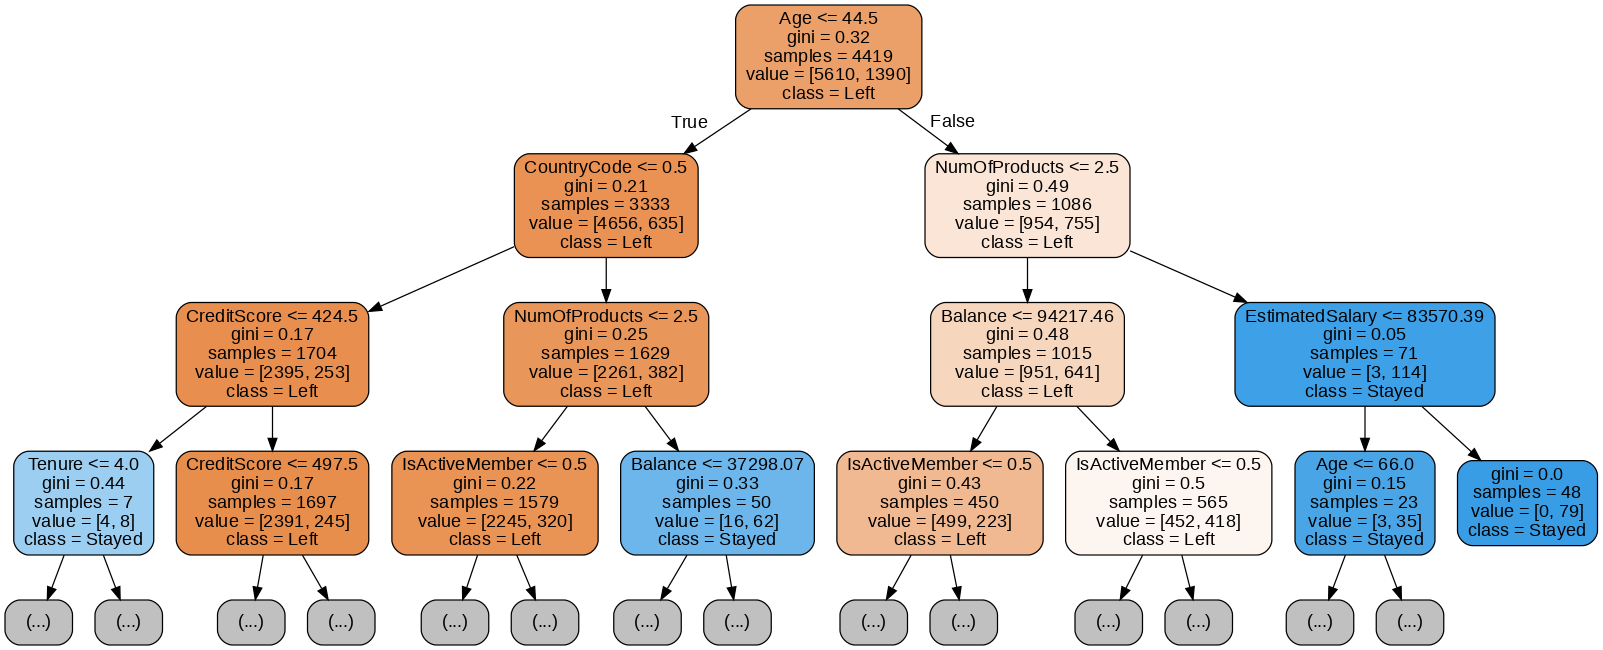

In [22]:
# Extract one of the trees from the model
tree = randomforest_classifier_m1.estimators_[6]

#defining features adn target variables
target = list(df_data['Exited'].unique())
feature_names = list(X.columns.values)

# Export as dot file
export_graphviz(tree, out_file='tree.dot',
feature_names =feature_names, class_names=['Left', 'Stayed'], rounded = True, proportion = False, precision = 2, filled = True, max_depth=3)
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=90'])
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

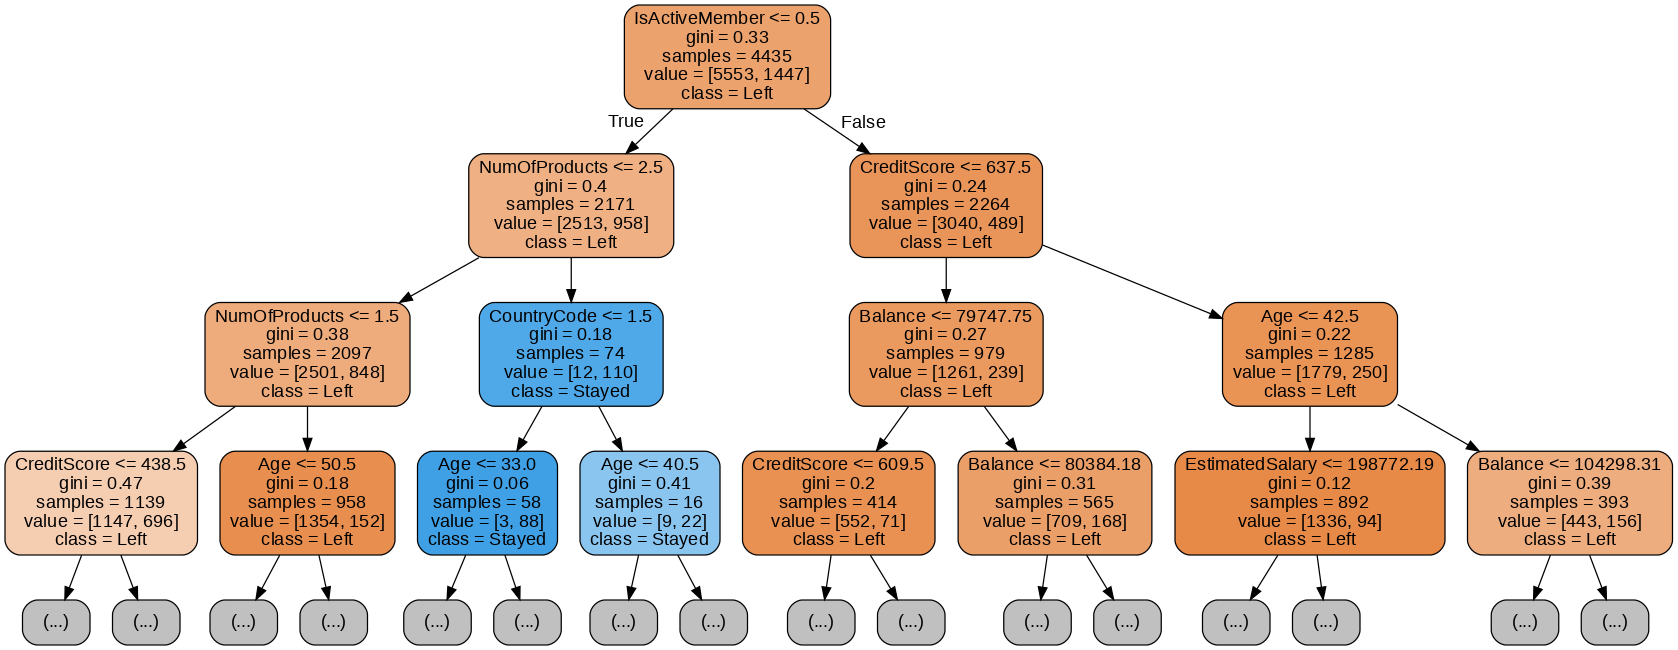

In [23]:
# Extract one of the trees from the model
tree = randomforest_classifier_m1.estimators_[8]

#defining features adn target variables
target = list(df_data['Exited'].unique())
feature_names = list(X.columns.values)

# Export as dot file
export_graphviz(tree, out_file='tree.dot',
feature_names =feature_names, class_names=['Left', 'Stayed'], rounded = True, proportion = False, precision = 2, filled = True, max_depth=3)
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=90'])
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

**Model 2 : Using Undersampled Data**

Resampling the dataset due to class imbalance

In [24]:
# summarize class distribution
print("Before undersampling: ", Counter(y_train))

# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

# summarize class distribution
print("After undersampling: ", Counter(y_train_under))

Before undersampling:  Counter({0: 5587, 1: 1413})
After undersampling:  Counter({0: 1413, 1: 1413})


In [25]:
# Create an object using RandomForestClassifier with default parameters
randomforest_classifier_m2 = RandomForestClassifier(random_state =100)
# Fit the classification model to the training set data.
randomforest_classifier_m2.fit(X_train_under, y_train_under)

RandomForestClassifier(random_state=100)

In [26]:
#Check how the model predicts testing data
y_predict_m2 = randomforest_classifier_m2.predict(X_test)
#creating confusion matrix
cm_m2 = confusion_matrix(y_test, y_predict_m2)

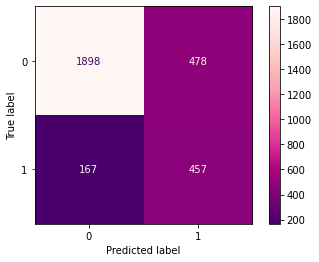

In [27]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_predict_m2, cmap='RdPu_r')
plt.grid(False)

In [28]:
#Classification report for testing data 
print(classification_report(y_test, y_predict_m2))

              precision    recall  f1-score   support

           0       0.92      0.80      0.85      2376
           1       0.49      0.73      0.59       624

    accuracy                           0.79      3000
   macro avg       0.70      0.77      0.72      3000
weighted avg       0.83      0.79      0.80      3000



In [29]:
ensemble_clfs = [
    (
        "RandomForestClassifier, max_features=0.4",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features=0.4,
            random_state=5,
        ),
    ),
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=5,
        ),
    ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=5,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 2000

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 50):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.


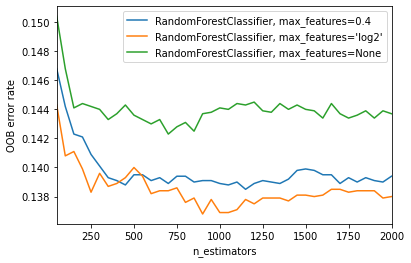

In [30]:
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

**Model 3 : Using Best parameters found**

In [31]:
# Create an object using RandomTreeClassifier, setting a few parameters.
randomforest_classifier_m3 = RandomForestClassifier(n_estimators = 930, criterion = 'gini',min_samples_split =10,min_samples_leaf =7,max_samples=0.85,
                                                 max_features='log2',max_depth=100,bootstrap=True,random_state =100,oob_score=True,class_weight="balanced_subsample")
randomforest_classifier_m3.fit(X_train, y_train)
y_predict_m3 = randomforest_classifier_m3.predict(X_test)
cm_m3 = confusion_matrix(y_test, y_predict_m3)

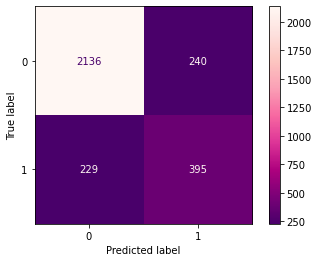

In [32]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_predict_m3, cmap='RdPu_r')
plt.grid(False)

In [33]:
#Classification report for testing data 
print(classification_report(y_test, y_predict_m3))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2376
           1       0.62      0.63      0.63       624

    accuracy                           0.84      3000
   macro avg       0.76      0.77      0.76      3000
weighted avg       0.84      0.84      0.84      3000



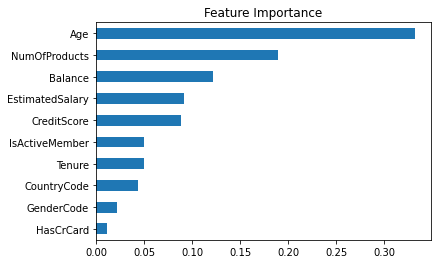

In [34]:
feat_importances = pd.Series(randomforest_classifier_m3.feature_importances_, index=X.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', title='Feature Importance')
plt.show()

In [35]:
#Model comparison
print('Model 1 : Baseline Model')
print(classification_report(y_test, y_predict_m1))
print('-----------------------------------------------------------------')
print('Model 2 : Using Undersampled Data')
print(classification_report(y_test, y_predict_m2))
print('-----------------------------------------------------------------')
print('Model 3 : Using Best parameters found ')
print(classification_report(y_test, y_predict_m3))
print('-----------------------------------------------------------------')

Model 1 : Baseline Model
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2376
           1       0.81      0.43      0.56       624

    accuracy                           0.86      3000
   macro avg       0.84      0.70      0.74      3000
weighted avg       0.85      0.86      0.84      3000

-----------------------------------------------------------------
Model 2 : Using Undersampled Data
              precision    recall  f1-score   support

           0       0.92      0.80      0.85      2376
           1       0.49      0.73      0.59       624

    accuracy                           0.79      3000
   macro avg       0.70      0.77      0.72      3000
weighted avg       0.83      0.79      0.80      3000

-----------------------------------------------------------------
Model 3 : Using Best parameters found 
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2376
       

**Conclusion**

1. Model 1 has the highest accuracy compared to the other two models but that is misleading.

2. We notice that model 1 has a very low recall and high precision for Prediction of class 1 but that flips in the subsequent models.

3. The f1-score is the best for our last model which gives us some confidence that the steps applied have improved the performance of the model

4. The support for Class 1 prediction is low (624) compared to Class 0 prediction (2376) which again shows the data has an imbalance issue.



